# Transfer learning with Tensorflow part 1: Feature extraction

Transfer learning is leveraging a wokring model's existing architecture and learned patterns for our own problems.

There are two main benefits:
1. Can leverage an existing neural network architecture proven to work on problems similar to our own.
2. Can leverage a working neural network architecture which has already learned patterns on similar data to our own, then we can adapt those patterns to our own data.

In [ ]:
!nvidia-smi

Fri Aug  6 10:02:45 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Download and becoming one with the data

In [ ]:
# Get data (10% of 10 food class in Food101 dataset) https://www.kaggle.com/dansbecker/food-101
import zipfile

# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2021-08-06 10:02:45--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.133.128, 74.125.140.128, 108.177.15.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.133.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  46.8MB/s    in 3.4s    

2021-08-06 10:02:50 (46.8 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# How many images in our directories
import os

# Walk through the 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

There are 2 directories and 0 images in 10_food_classes_10_percent
There are 10 directories and 0 images in 10_food_classes_10_percent/train
There are 0 directories and 75 images in 10_food_classes_10_percent/train/ramen
There are 0 directories and 75 images in 10_food_classes_10_percent/train/pizza
There are 0 directories and 75 images in 10_food_classes_10_percent/train/chicken_wings
There are 0 directories and 75 images in 10_food_classes_10_percent/train/sushi
There are 0 directories and 75 images in 10_food_classes_10_percent/train/chicken_curry
There are 0 directories and 75 images in 10_food_classes_10_percent/train/fried_rice
There are 0 directories and 75 images in 10_food_classes_10_percent/train/steak
There are 0 directories and 75 images in 10_food_classes_10_percent/train/hamburger
There are 0 directories and 75 images in 10_food_classes_10_percent/train/grilled_salmon
There are 0 directories and 75 images in 10_food_classes_10_percent/train/ice_cream
There are 10 director

## Create the data loaders (preparing the data)

We'll use the `ImageDataGenerator` class to load in our images in batches.

In [ ]:
# Set up data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SHAPE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 5

# Specify the train and the test directories
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

print("Training image:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                              target_size=IMG_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")
print("Testing image:")
test_data_10_percent = test_datagen.flow_from_directory(test_dir,
                                            target_size=IMG_SHAPE,
                                            batch_size=BATCH_SIZE,
                                            class_mode="categorical")

Training image:
Found 750 images belonging to 10 classes.
Testing image:
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run whilst our model train)

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks:
* Tracking experiments with `TensorBoard` callback.
* Model checkpoint with `ModelCheckpoint` callback.
* Stop a model from training (before its train too long and overfits) with `EarlyStopping` callback.

In [ ]:
# Create TensorBoard callback (functionized because we need to create a new one for each model)
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving Tensorboard log files to {log_dir}")
  return tensorboard_callback

## Create models using Tensorflow Hub

We can access pretrained model on: https://tfhub.dev

Browsing the Tensorflow Hub page and sorting for image classification, we found the following feature vector model link: https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1 

In [11]:
# Let's compare the following two models
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [12]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [53]:
# Let's make a create_model() function to create a model from tensorflow hub URL
def create_model(model_url, num_classes=10):
  """
  Takes a TensorFlow Hub URL and creates a Keras Sequential model with it
  
  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_class (int): Number of output neurons in the output layer,
                    should be equal to number of target class, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor layer 
    and Dense output layer with num_classes ouput neurons.
  """
  # Download the pretrained model and save it as keras layer
  feature_extractor_layer = hub.KerasLayer(model_url, 
                                           trainable=False,
                                           name="feature_extraction_layer",
                                           input_shape=IMG_SHAPE+(3,)) # Freeze the already learned patterns
  if num_classes>2:                                         
    # Create our own model
    model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes, activation="softmax", name="output_layer")
    ])
  else:
    # Create our own model
    model = tf.keras.Sequential([
      tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
      tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
      tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
      feature_extractor_layer,
      layers.Dense(1, activation="sigmoid", name="output_layer")
    ])
  
  return model


### Creating ResNet TensorFlow Hub Feature Extraction model

In [ ]:
# Create Resnet Model
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)

In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 2048)              23564800  
_________________________________________________________________
output_layer (Dense)         (None, 10)                20490     
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
# Compile our Resnet model
resnet_model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [ ]:
# Let's fit our ResNet model to the data (10 percent of the 10 classes dataset)
history_resnet = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data_10_percent,
                                  validation_steps=len(test_data_10_percent),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",experiment_name="reset50v2")])

Saving Tensorboard log files to tensorflow_hub/reset50v2/20210806-100307
Epoch 1/5
24/24 [==============================] - 58s 1s/step - loss: 1.8779 - accuracy: 0.3733 - val_loss: 1.2051 - val_accuracy: 0.6100
Epoch 2/5
24/24 [==============================] - 22s 927ms/step - loss: 0.9218 - accuracy: 0.7040 - val_loss: 0.8888 - val_accuracy: 0.7048
Epoch 3/5
24/24 [==============================] - 22s 928ms/step - loss: 0.6275 - accuracy: 0.8253 - val_loss: 0.7705 - val_accuracy: 0.7524
Epoch 4/5
24/24 [==============================] - 22s 931ms/step - loss: 0.4805 - accuracy: 0.8760 - val_loss: 0.7119 - val_accuracy: 0.7660
Epoch 5/5
24/24 [==============================] - 22s 931ms/step - loss: 0.3852 - accuracy: 0.9187 - val_loss: 0.6902 - val_accuracy: 0.7736


Wow!

That's is incredible. Our transfer learing feature extractor model out performed ALL of the previous models we built by hand... (substantially) and in a quicker training time and with only 10% of the training example (the test set is the same).

In [9]:
import matplotlib.pyplot as plt

# Let's create a function to plot our loss curves
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation curves
  
  Args:
    history: Tensorflow History object.
  
  Returns:
    Plots of training/validation loss and accuracy metrics.
  """

  loss = history.history["loss"]
  val_loss = history.history["val_loss"]
  
  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))
  # Plot
  plt.figure(figsize=(12,6))
  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="training_val_loss")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="training_val_accuracy")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend()
  
  plt.show()
  

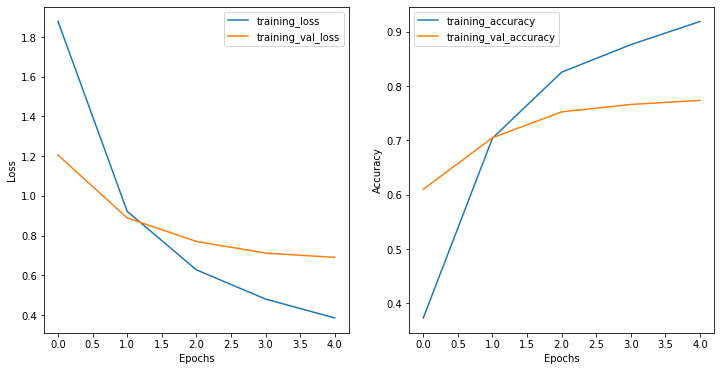

In [ ]:
plot_loss_curves(history_resnet)

### Creating and testing EfficientNet Tensorflow Hub Feature Extraction model

In [ ]:
# Create EfficientNet
effnet_model = create_model(efficientnet_url,
                       num_classes=train_data_10_percent.num_classes)

In [ ]:
effnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 1280)              4049564   
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [ ]:
effnet_model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [ ]:
history_effnet = effnet_model.fit(train_data_10_percent,
                            epochs=5,
                            steps_per_epoch=len(train_data_10_percent),
                            validation_data=test_data_10_percent,
                            validation_steps=len(test_data_10_percent),
                            callbacks=[create_tensorboard_callback("tensorflow_hub", "efficientnetb0")])

Saving Tensorboard log files to tensorflow_hub/efficientnetb0/20210806-100731
Epoch 1/5
24/24 [==============================] - 34s 1s/step - loss: 1.8759 - accuracy: 0.4200 - val_loss: 1.3369 - val_accuracy: 0.6912
Epoch 2/5
24/24 [==============================] - 19s 835ms/step - loss: 1.0795 - accuracy: 0.7653 - val_loss: 0.8942 - val_accuracy: 0.8152
Epoch 3/5
24/24 [==============================] - 19s 836ms/step - loss: 0.7670 - accuracy: 0.8333 - val_loss: 0.7133 - val_accuracy: 0.8376
Epoch 4/5
24/24 [==============================] - 19s 823ms/step - loss: 0.6151 - accuracy: 0.8693 - val_loss: 0.6242 - val_accuracy: 0.8488
Epoch 5/5
24/24 [==============================] - 19s 818ms/step - loss: 0.5146 - accuracy: 0.8880 - val_loss: 0.5655 - val_accuracy: 0.8572


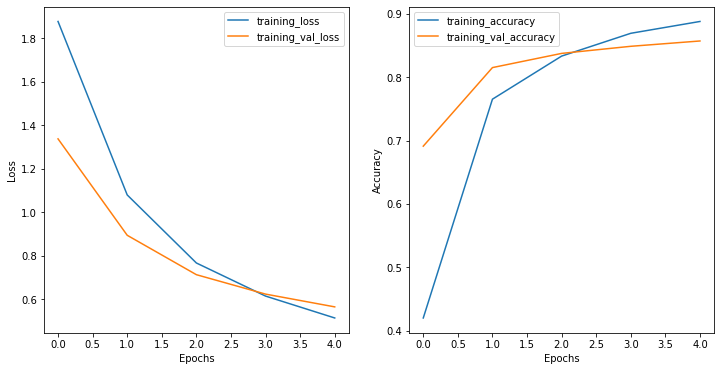

In [ ]:
plot_loss_curves(history_effnet)

In [ ]:
effnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 1280)              4049564   
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 2048)              23564800  
_________________________________________________________________
output_layer (Dense)         (None, 10)                20490     
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


## Different types of transfer learning

* **"As is"** transfer learning - using an existing model with no change whatsoever (e.g using ImageNet model on 1000 ImageNet classes, none of you own)
* **"Feature extraction"** transfer learning - use the prelearned patterns of an existing model (e.g EfficientNetB0 trained on ImageNet) and adjust the output layer for your own problem (e.g 1000 classes -> 10 classes of food)
* "Fine-Tuning" transfer learning - use the prelearned patterns of an existing model and "fine-tune" many or all of the underlying layer ()

## Comparing our models results using TensorBoard

>🔑**Note:** When upload things to the TensorBoard.dev, your expriments are public.

In [ ]:
# Upload TensorBoard dev record
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs ResNet50v2" \
  --description "Comparing two different TF Hub extraction model architectures using 10% of the dataset" \
  --one_shot

2021-08-06 10:11:51.422779: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) y

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0

Our Tensorboard experiments are uploaded publically at :https://tensorboard.dev/experiment/xRYZEQYwQmy9baI1z65Ykg/

In [ ]:
!tensorboard dev list

2021-08-06 10:14:10.628748: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
https://tensorboard.dev/experiment/xRYZEQYwQmy9baI1z65Ykg/
	Name                 EfficientNetB0 vs ResNet50v2
	Description          Comparing two different TF Hub extraction model architectures using 10% of the dataset
	Id                   xRYZEQYwQmy9baI1z65Ykg
	Created              2021-08-06 10:12:11 (2 minutes ago)
	Updated              2021-08-06 10:12:14 (2 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  6086643
Total: 1 experiment(s)


# Transfer Learning on Another dataset

## Get dataset

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [15]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file("cats_and_dogs.zip", origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SHAPE = (224, 224)

In [18]:
train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SHAPE)

validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SHAPE)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


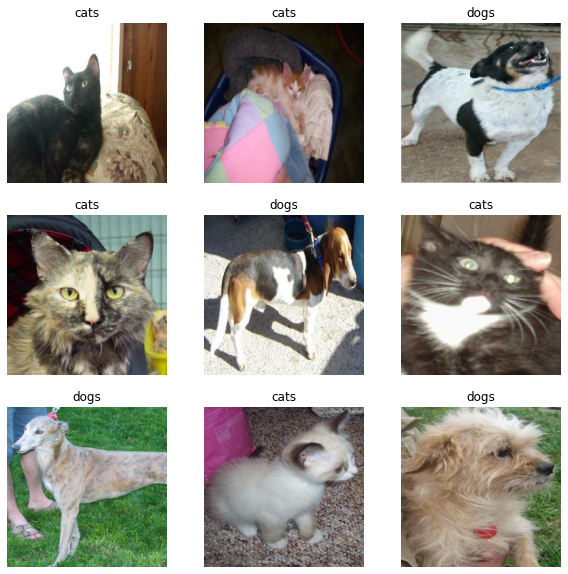

In [20]:
class_names = train_dataset.class_names

plt.figure(figsize=(10,10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis(False)

## Configure dataset

As the original dataset doesn't contain a test set, you will create one. To do so, determine how many batches of data are available in the validation set using tf.data.experimental.cardinality, then move 20% of them to a test set.

In [21]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches//5)
validation_dataset = validation_dataset.skip(val_batches//5)

In [22]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


## Configure dataset performance
Use buffered prefetching to load images from disk without having I/O become blocking. To learn more about this method see [the data performance](https://www.tensorflow.org/guide/data_performance) guide.

In [27]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [34]:
efficientNet_model = create_model(efficientnet_url, num_classes=2)

In [35]:
efficientNet_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 1280)              4049564   
_________________________________________________________________
output_layer (Dense)         (None, 1)                 1281      
Total params: 4,050,845
Trainable params: 1,281
Non-trainable params: 4,049,564
_________________________________________________________________


In [36]:
efficientNet_model.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [37]:
history_catdog = efficientNet_model.fit(train_dataset,
                                        epochs=20,
                                        steps_per_epoch=len(train_dataset),
                                        validation_data=validation_dataset,
                                        validation_steps=len(validation_dataset))

Epoch 1/20
63/63 [==============================] - 15s 110ms/step - loss: 264.0747 - accuracy: 0.4980 - val_loss: 174.2756 - val_accuracy: 0.5285
Epoch 2/20
63/63 [==============================] - 6s 96ms/step - loss: 151.8391 - accuracy: 0.5285 - val_loss: 145.2450 - val_accuracy: 0.5297
Epoch 3/20
63/63 [==============================] - 6s 94ms/step - loss: 115.0403 - accuracy: 0.5485 - val_loss: 140.0417 - val_accuracy: 0.5198
Epoch 4/20
63/63 [==============================] - 6s 92ms/step - loss: 118.5487 - accuracy: 0.5505 - val_loss: 154.6440 - val_accuracy: 0.5260
Epoch 5/20
63/63 [==============================] - 6s 93ms/step - loss: 79.5885 - accuracy: 0.5720 - val_loss: 126.8914 - val_accuracy: 0.5557
Epoch 6/20
63/63 [==============================] - 6s 92ms/step - loss: 83.3801 - accuracy: 0.5660 - val_loss: 143.3445 - val_accuracy: 0.5582
Epoch 7/20
63/63 [==============================] - 6s 93ms/step - loss: 72.5538 - accuracy: 0.5820 - val_loss: 134.4144 - val_acc

In [41]:
resnet_model = create_model(resnet_url, num_classes=2)

In [42]:
resnet_model.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [43]:
history_catdog_resnet = resnet_model.fit(train_dataset,
                                        epochs=10,
                                        steps_per_epoch=len(train_dataset),
                                        validation_data=validation_dataset,
                                        validation_steps=len(validation_dataset))

Epoch 1/10
63/63 [==============================] - 11s 130ms/step - loss: 12.9209 - accuracy: 0.5270 - val_loss: 6.5298 - val_accuracy: 0.6052
Epoch 2/10
63/63 [==============================] - 8s 123ms/step - loss: 7.6684 - accuracy: 0.5445 - val_loss: 4.5364 - val_accuracy: 0.6077
Epoch 3/10
63/63 [==============================] - 8s 123ms/step - loss: 5.3912 - accuracy: 0.5540 - val_loss: 4.5425 - val_accuracy: 0.5965
Epoch 4/10
63/63 [==============================] - 8s 124ms/step - loss: 5.4202 - accuracy: 0.5615 - val_loss: 6.7831 - val_accuracy: 0.5433
Epoch 5/10
63/63 [==============================] - 8s 126ms/step - loss: 6.2589 - accuracy: 0.5740 - val_loss: 3.5026 - val_accuracy: 0.6139
Epoch 6/10
63/63 [==============================] - 8s 125ms/step - loss: 3.9571 - accuracy: 0.5965 - val_loss: 5.0050 - val_accuracy: 0.5941
Epoch 7/10
63/63 [==============================] - 8s 126ms/step - loss: 3.8034 - accuracy: 0.6140 - val_loss: 4.1272 - val_accuracy: 0.5705
Epoc

In [44]:
mobilenet_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

In [49]:
mobilenet_model = create_model(mobilenet_url, num_classes=2)

In [50]:
mobilenet_model.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [51]:
history_catdog_mobilenet = mobilenet_model.fit(train_dataset,
                                        epochs=10,
                                        steps_per_epoch=len(train_dataset),
                                        validation_data=validation_dataset,
                                        validation_steps=len(validation_dataset))

Epoch 1/10
63/63 [==============================] - 9s 83ms/step - loss: 0.4305 - accuracy: 0.7875 - val_loss: 0.2233 - val_accuracy: 0.9171
Epoch 2/10
63/63 [==============================] - 5s 77ms/step - loss: 0.2691 - accuracy: 0.8895 - val_loss: 0.1853 - val_accuracy: 0.9245
Epoch 3/10
63/63 [==============================] - 5s 81ms/step - loss: 0.2613 - accuracy: 0.8765 - val_loss: 0.1601 - val_accuracy: 0.9381
Epoch 4/10
63/63 [==============================] - 5s 81ms/step - loss: 0.2285 - accuracy: 0.8985 - val_loss: 0.1568 - val_accuracy: 0.9332
Epoch 5/10
63/63 [==============================] - 5s 81ms/step - loss: 0.2227 - accuracy: 0.9015 - val_loss: 0.1531 - val_accuracy: 0.9344
Epoch 6/10
63/63 [==============================] - 5s 82ms/step - loss: 0.2242 - accuracy: 0.9035 - val_loss: 0.1524 - val_accuracy: 0.9356
Epoch 7/10
63/63 [==============================] - 5s 79ms/step - loss: 0.2092 - accuracy: 0.9085 - val_loss: 0.1482 - val_accuracy: 0.9381
Epoch 8/10
63

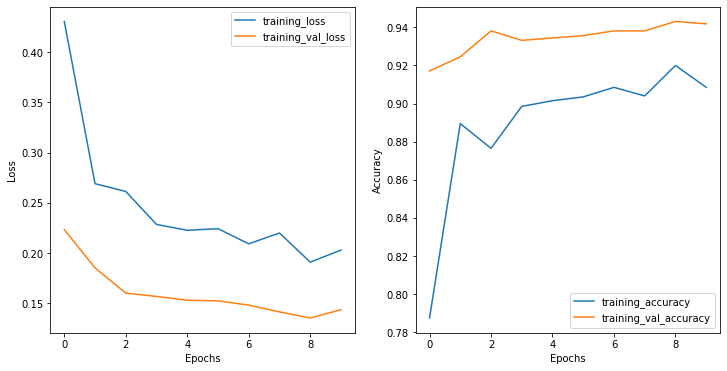

In [52]:
plot_loss_curves(history_catdog_mobilenet)

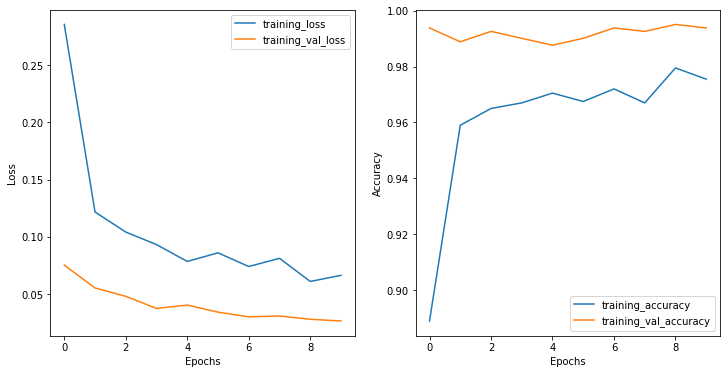

In [56]:
plot_loss_curves(history_catdog_mobilenet_2)

In [54]:
mobilenet_model_2 = create_model(mobilenet_url, num_classes=2)

mobilenet_model_2.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [55]:
history_catdog_mobilenet_2 = mobilenet_model_2.fit(train_dataset,
                                        epochs=10,
                                        steps_per_epoch=len(train_dataset),
                                        validation_data=validation_dataset,
                                        validation_steps=len(validation_dataset))

Epoch 1/10
63/63 [==============================] - 9s 88ms/step - loss: 0.2854 - accuracy: 0.8890 - val_loss: 0.0753 - val_accuracy: 0.9938
Epoch 2/10
63/63 [==============================] - 5s 81ms/step - loss: 0.1216 - accuracy: 0.9590 - val_loss: 0.0553 - val_accuracy: 0.9889
Epoch 3/10
63/63 [==============================] - 5s 76ms/step - loss: 0.1041 - accuracy: 0.9650 - val_loss: 0.0480 - val_accuracy: 0.9926
Epoch 4/10
63/63 [==============================] - 5s 82ms/step - loss: 0.0932 - accuracy: 0.9670 - val_loss: 0.0375 - val_accuracy: 0.9901
Epoch 5/10
63/63 [==============================] - 5s 82ms/step - loss: 0.0785 - accuracy: 0.9705 - val_loss: 0.0404 - val_accuracy: 0.9876
Epoch 6/10
63/63 [==============================] - 5s 82ms/step - loss: 0.0860 - accuracy: 0.9675 - val_loss: 0.0342 - val_accuracy: 0.9901
Epoch 7/10
63/63 [==============================] - 5s 81ms/step - loss: 0.0740 - accuracy: 0.9720 - val_loss: 0.0301 - val_accuracy: 0.9938
Epoch 8/10
63